/tmp/ipykernel_20341/756223877.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['avg_total_case'] = (data_filtered['total_case_agent_0'] + data_filtered['total_case_agent_1']) / 2
/tmp/ipykernel_20341/756223877.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['avg_total_case'] = (data_filtered['total_case_agent_0'] + data_filtered['total_case_agent_1']) / 2
/tmp/ipykernel_20341/756223877.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

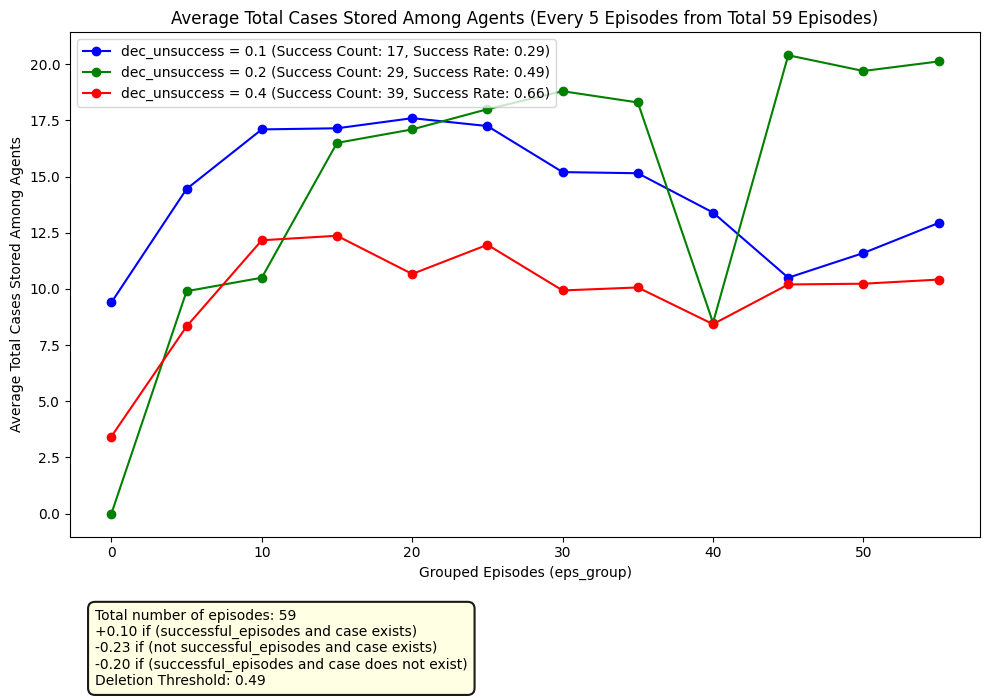

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Folder path containing CSV files in the current directory
folder_path = './'

# Variable to control how many episodes to average together
episodes_per_average = 1

# Initialize an empty list to hold data from all files
all_data_frames = []

# Loop through all CSV files in the specified folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        # Load the data from the CSV file and append to the list
        df = pd.read_csv(file_path)
        all_data_frames.append(df)

# If no CSV files are found, exit without generating the graph
if len(all_data_frames) == 0:
    print("No CSV files found in the specified folder.")
else:
    # Concatenate all data frames into a single data frame
    combined_data = pd.concat(all_data_frames, ignore_index=True)

    # Create a new column for grouping episodes in batches
    combined_data['eps_group'] = (combined_data['eps'] // episodes_per_average) * episodes_per_average

    # Group by 'eps_group' and 'dec_unsuccess', then calculate the average values for all episodes (successful and unsuccessful)
    grouped_data = combined_data.groupby(['eps_group', 'dec_unsuccess']).mean().reset_index()

    # Find unique values of 'dec_unsuccess' for coloring different lines
    unique_dec_unsuccess_values = grouped_data['dec_unsuccess'].unique()

    # Calculate the success count and total number of episodes for each `dec_unsuccess` value
    success_count = combined_data[combined_data['eps_status'] == 1].groupby('dec_unsuccess').size().reset_index(name='success_count')
    total_episodes_info = combined_data[['dec_unsuccess', 'eps']].drop_duplicates().groupby('dec_unsuccess').size().reset_index(name='total_episodes')

    # Calculate the success rate by dividing the success count by the total episodes
    success_info = pd.merge(success_count, total_episodes_info, on='dec_unsuccess')
    success_info['success_rate'] = success_info['success_count'] / success_info['total_episodes']

    # Plot: Average Total Cases Stored Among Agents Across All Episodes
    plt.figure(figsize=(10, 6))

    # Define a set of colors to use for different lines
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    # Plot the average total cases for each `dec_unsuccess` value
    for i, dec_value in enumerate(unique_dec_unsuccess_values):
        # Filter the data for the current `dec_unsuccess` value
        data_filtered = grouped_data[grouped_data['dec_unsuccess'] == dec_value]
        # Calculate average total cases stored among agents
        data_filtered['avg_total_case'] = (data_filtered['total_case_agent_0'] + data_filtered['total_case_agent_1']) / 2
        # Extract the success rate and count for the current `dec_unsuccess` value
        count = success_info[success_info['dec_unsuccess'] == dec_value]['success_count'].values[0]
        rate = success_info[success_info['dec_unsuccess'] == dec_value]['success_rate'].values[0]
        # Plot the line for the current `dec_unsuccess` value
        plt.plot(data_filtered['eps_group'], data_filtered['avg_total_case'], label=f'dec_unsuccess = {dec_value} (Success Count: {count:.0f}, Success Rate: {rate:.2f})', color=colors[i % len(colors)], marker='o')

    # Set chart title and labels
    total_episodes = combined_data['eps'].nunique()
    plt.title(f"Average Total Cases Stored Among Agents (Every {episodes_per_average} Episodes from Total {total_episodes} Episodes)")
    plt.xlabel('Grouped Episodes (eps_group)')
    plt.ylabel('Average Total Cases Stored Among Agents')

    # Keep the original legend inside the graph without a title
    plt.legend(loc='upper left')

    # Extract non-graphical data for display (averaged across all files)
    non_graphical_data = grouped_data[['inc_success', 'dec_unsuccess', 'dec_success_nocase', 'del_threshold']].mean().to_dict()

    # Combine all additional formatted information into one text block, including the number of episodes
    legend_text = (
        f"Total number of episodes: {combined_data['eps'].nunique()}\n"
        f"+{non_graphical_data['inc_success']:.2f} if (successful_episodes and case exists)\n"
        f"-{non_graphical_data['dec_unsuccess']:.2f} if (not successful_episodes and case exists)\n"
        f"-{non_graphical_data['dec_success_nocase']:.2f} if (successful_episodes and case does not exist)\n"
        f"Deletion Threshold: {non_graphical_data['del_threshold']:.2f}"
    )

    # Add the combined formatted information below the plot with a single enhanced box and adjust positioning closer to the plot
    props = dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='lightyellow', alpha=0.9, linewidth=1.5)
    plt.figtext(0.1, -0.15, legend_text, fontsize=10, ha='left', bbox=props)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()
